In [171]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chi2_contingency, ttest_ind
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [47]:
df = pd.read_csv('../data/bank-full.csv', sep=';')
print(df.dtypes)
df

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [48]:
print("\n", "Missing Value: " + str(df.isnull().values.any()), '\n', "Duplicated Rows: " + str(df.duplicated().any()))


 Missing Value: False 
 Duplicated Rows: False


In [49]:
X_num = df.drop(columns=['y']).select_dtypes(include=np.number)
X_num

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0
...,...,...,...,...,...,...,...
45206,51,825,17,977,3,-1,0
45207,71,1729,17,456,2,-1,0
45208,72,5715,17,1127,5,184,3
45209,57,668,17,508,4,-1,0


In [50]:
X_obj = df.drop(columns=['y']+list(X_num.columns))
X_obj

,job,marital,education,default,housing,loan,contact,month,poutcome
0,management,married,tertiary,no,yes,no,unknown,may,unknown
1,technician,single,secondary,no,yes,no,unknown,may,unknown
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown
4,unknown,single,unknown,no,no,no,unknown,may,unknown
...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,cellular,nov,unknown
45207,retired,divorced,primary,no,no,no,cellular,nov,unknown
45208,retired,married,secondary,no,no,no,cellular,nov,success
45209,blue-collar,married,secondary,no,no,no,telephone,nov,unknown


In [51]:
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

<AxesSubplot:>

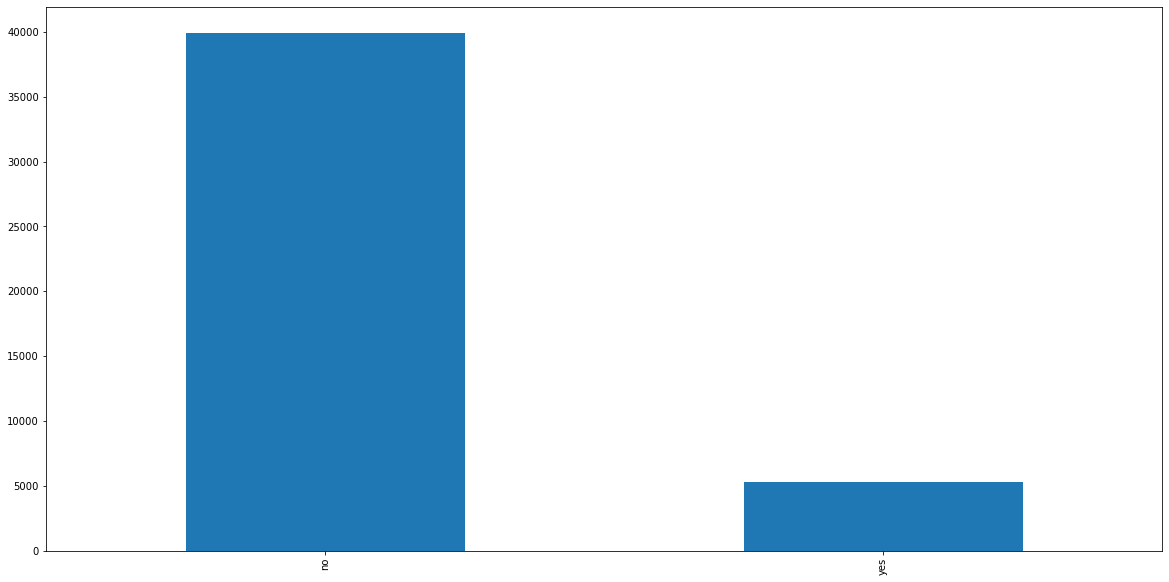

In [52]:
plt.figure(figsize=(20, 10))
df.y.value_counts().plot(kind='bar')

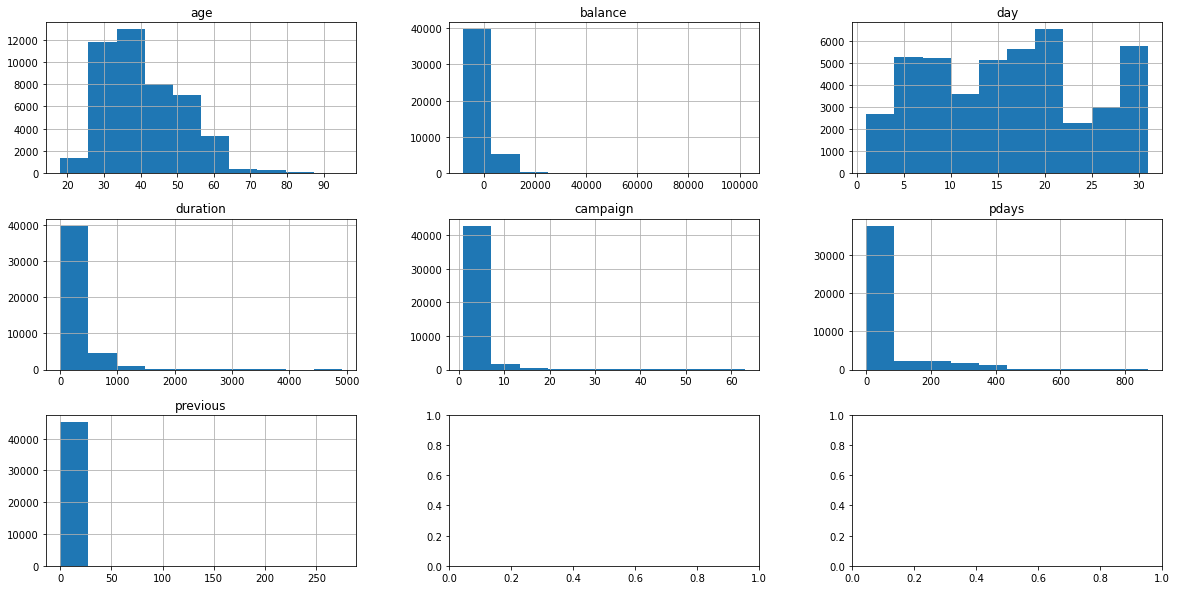

In [53]:
columns = X_num.columns
fig, axs = plt.subplots(3, 3, figsize=(20, 10)) #necessary line
for ax, col in zip(axs.flatten(), columns):
    X_num.hist(column=col, ax=ax)

In [54]:
# X_num_log = pd.DataFrame(columns=X_num.columns)
# for fea in X_num.columns:
#     X_num_log[fea] = np.log2(X_num[fea]+(-X_num[fea].min())+1e-100)
# X_num_log

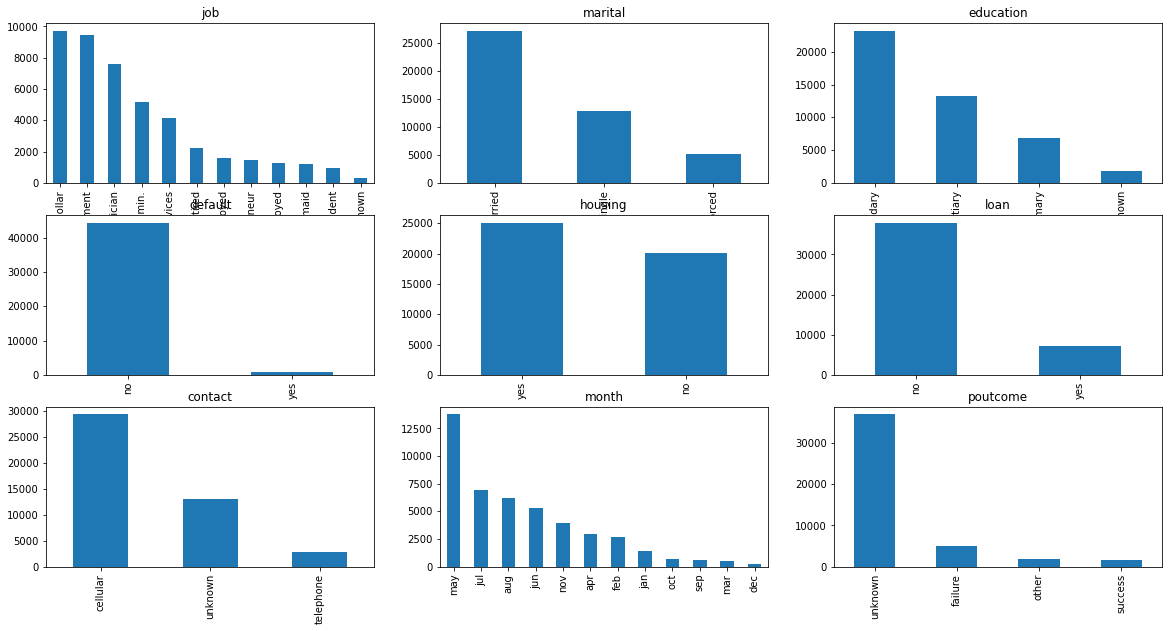

In [55]:
columns = X_obj.columns
fig, axs = plt.subplots(3, 3, figsize=(20, 10)) 
for ax, col in zip(axs.flatten(), columns):
    X_obj[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(col)

### 2.1 Filtering Feature Selection on numeric features

In [56]:
pvals = []
for fea in X_num.columns:
    t_sts, p = ttest_ind(df[df['y']=='yes'][fea], df[df['y']=='no'][fea])
    pvals.append(p)
sig_num = pd.DataFrame(zip(X_num.columns, pvals), columns=['Feature', 'p-Value']).sort_values(by='p-Value')
sig_num

,Feature,p-Value
3,duration,0.000000e+00
5,pdays,3.790553e-108
6,previous,7.801830e-88
4,campaign,1.012347e-54
1,balance,2.521114e-29
2,day,1.653880e-09
0,age,8.825644e-08


### 2.2 Filtering Feature Selection on categorical features

In [57]:
pvals2 = []
for fea in X_obj.columns:
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(df.y, df[fea]))
    pvals2.append(p)
sig_obj = pd.DataFrame(zip(X_obj.columns, pvals2), columns=['Feature', 'p-Value']).sort_values(by='p-Value')
sig_obj

,Feature,p-Value
7,month,0.000000e+00
8,poutcome,0.000000e+00
6,contact,1.251738e-225
4,housing,2.918798e-192
0,job,3.337122e-172
2,education,1.626656e-51
5,loan,1.665061e-47
1,marital,2.145100e-43
3,default,2.453861e-06


In [58]:
sig_num_col = list(sig_num[sig_num['p-Value']<0.05]['Feature'])
sig_obj_col = list(sig_obj[sig_obj['p-Value']<0.05]['Feature'])

### 2.3 Convert categorical variable to numerical by one-hot encoding
Binay variables will be converted to 1/0 to aviod redendancy, since if use one-hot enconding, the two new features will be perfectly correlated

In [136]:
df_sig = df[sig_num_col+sig_obj_col+['y']]
df_sig = df_sig.replace({'housing': {'yes': 1, 'no': 0}})
df_sig = df_sig.replace({'loan': {'yes': 1, 'no': 0}})
df_sig = df_sig.replace({'y': {'yes': 1, 'no': 0}})
print(df_sig.shape)
df_sig = pd.get_dummies(df_sig)
print(df_sig.shape)
df_sig

(45211, 17)
(45211, 50)


,duration,pdays,previous,campaign,balance,day,age,housing,loan,y,...,job_unknown,education_primary,education_secondary,education_tertiary,education_unknown,marital_divorced,marital_married,marital_single,default_no,default_yes
0,261,-1,0,1,2143,5,58,1,0,0,...,0,0,0,1,0,0,1,0,1,0
1,151,-1,0,1,29,5,44,1,0,0,...,0,0,1,0,0,0,0,1,1,0
2,76,-1,0,1,2,5,33,1,1,0,...,0,0,1,0,0,0,1,0,1,0
3,92,-1,0,1,1506,5,47,1,0,0,...,0,0,0,0,1,0,1,0,1,0
4,198,-1,0,1,1,5,33,0,0,0,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,977,-1,0,3,825,17,51,0,0,1,...,0,0,0,1,0,0,1,0,1,0
45207,456,-1,0,2,1729,17,71,0,0,1,...,0,1,0,0,0,1,0,0,1,0
45208,1127,184,3,5,5715,17,72,0,0,1,...,0,0,1,0,0,0,1,0,1,0
45209,508,-1,0,4,668,17,57,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [137]:
X = df_sig.drop(columns=['y'])
y = df_sig['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=888)

In [138]:
rf = RandomForestClassifier(max_depth=5, random_state=888, class_weight= 'balanced')
lasso = LogisticRegression(solver = 'liblinear', penalty='l1', class_weight = 'balanced', random_state=888)
svc = SVC(class_weight='balanced', C=2, random_state=888)
knn = KNeighborsClassifier(n_neighbors=10)
elasticnet = SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=0.6,  random_state=888, class_weight='balanced')
classifiers = [rf, lasso, svc, knn, elasticnet]
classifier_names = ['Random Forest', 'LASSO', 'Support Vector Machine', 'k-Nearest Neighbor', 'ElasticNet']

In [139]:
def train_test_evaluate(clf, clf_name, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    f1 = metrics.f1_score(y_test, pred, average = 'macro')
    pre = metrics.precision_score(y_test, pred, average='macro')
    rec = metrics.recall_score(y_test, pred, average = 'macro')
    acc = metrics.accuracy_score(y_test, pred)
    print("The Test Result for Classifier: " + clf_name)
    print(metrics.classification_report(y_test, pred, target_names=['no', 'yes']))
    cm = metrics.confusion_matrix(y_test, pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return(f1, pre, rec, acc, clf)

In [140]:
def compare_classifers(X_train, y_train, X_test, y_test, clfs, clf_names):
    f1scores = []
    precisions = []
    recalls = []
    accuracies = []
    fitted_clfs = []
    for i in range(len(clfs)):
        f1, pre, rec, acc, fitted_clf = train_test_evaluate(clfs[i], clf_names[i], X_train, y_train, X_test, y_test)
        f1scores.append(f1)
        precisions.append(pre)
        recalls.append(rec)
        accuracies.append(acc)
        fitted_clfs.append(fitted_clf)
    df_evl = pd.DataFrame(zip(clf_names, accuracies, precisions, recalls,f1scores), 
                          columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1Score']).sort_values(by='F1Score', ascending=False)
    return(df_evl, fitted_clfs)

The Test Result for Classifier: Random Forest
              precision    recall  f1-score   support

          no       0.97      0.82      0.89     31962
         yes       0.37      0.83      0.51      4207

    accuracy                           0.82     36169
   macro avg       0.67      0.82      0.70     36169
weighted avg       0.90      0.82      0.84     36169



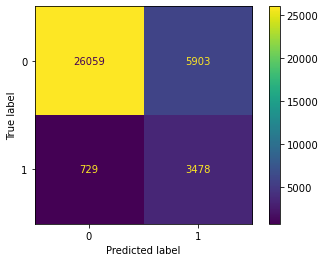

The Test Result for Classifier: LASSO
              precision    recall  f1-score   support

          no       0.97      0.85      0.91     31962
         yes       0.42      0.81      0.55      4207

    accuracy                           0.85     36169
   macro avg       0.69      0.83      0.73     36169
weighted avg       0.91      0.85      0.87     36169



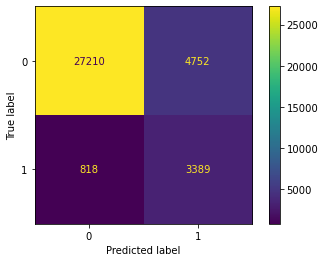

The Test Result for Classifier: Support Vector Machine
              precision    recall  f1-score   support

          no       0.95      0.80      0.87     31962
         yes       0.31      0.67      0.42      4207

    accuracy                           0.79     36169
   macro avg       0.63      0.74      0.65     36169
weighted avg       0.87      0.79      0.82     36169



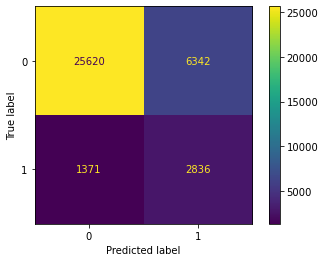

The Test Result for Classifier: k-Nearest Neighbor
              precision    recall  f1-score   support

          no       0.90      0.98      0.94     31962
         yes       0.51      0.14      0.22      4207

    accuracy                           0.88     36169
   macro avg       0.70      0.56      0.58     36169
weighted avg       0.85      0.88      0.85     36169



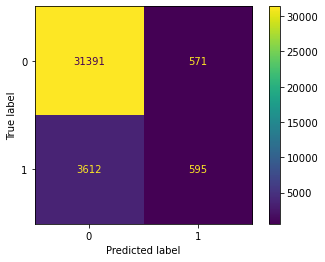

The Test Result for Classifier: ElasticNet
              precision    recall  f1-score   support

          no       0.92      0.89      0.91     31962
         yes       0.34      0.42      0.38      4207

    accuracy                           0.84     36169
   macro avg       0.63      0.66      0.64     36169
weighted avg       0.85      0.84      0.85     36169



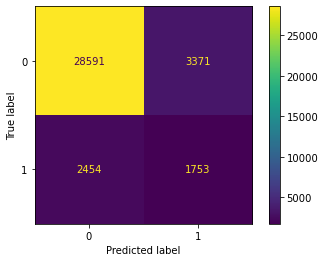

,Classifier,Accuracy,Precision,Recall,F1Score
1,LASSO,0.846001,0.693551,0.828443,0.728033
0,Random Forest,0.816639,0.671768,0.821015,0.699519
2,Support Vector Machine,0.786751,0.629103,0.737846,0.646462
4,ElasticNet,0.838950,0.631534,0.655609,0.641643
3,k-Nearest Neighbor,0.884348,0.703550,0.561783,0.579506


In [141]:
df_compare_res, fitted_clfs = compare_classifers(X_train, y_train, X_test, y_test, classifiers, classifier_names)
df_compare_res

In [142]:
df_rf_fea_imp = pd.DataFrame(zip(X_train.columns, fitted_clfs[0].feature_importances_), 
                             columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
df_rf_fea_imp[df_rf_fea_imp.importance>0.01]

,feature,importance
0,duration,0.416096
23,poutcome_success,0.104356
27,contact_unknown,0.062056
7,housing,0.056478
1,pdays,0.049435
25,contact_cellular,0.048851
6,age,0.033658
24,poutcome_unknown,0.031673
2,previous,0.025422
4,balance,0.023112


In [143]:
df_rf_fea_imp

,feature,importance
0,duration,0.416096
23,poutcome_success,0.104356
27,contact_unknown,0.062056
7,housing,0.056478
1,pdays,0.049435
25,contact_cellular,0.048851
6,age,0.033658
24,poutcome_unknown,0.031673
2,previous,0.025422
4,balance,0.023112


In [144]:
df_lasso_fea_imp = pd.DataFrame(zip(X_train.columns, fitted_clfs[1].coef_[0]), 
                             columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
df_lasso_fea_imp[(df_lasso_fea_imp.importance>1)|(df_lasso_fea_imp.importance<-1)]

,feature,importance
23,poutcome_success,2.438709
16,month_mar,2.300346
20,month_sep,1.306653
19,month_oct,1.277687
18,month_nov,-1.169700
13,month_jan,-1.182409
14,month_jul,-1.207872
27,contact_unknown,-1.914503


In [145]:
df_lasso_fea_imp

,feature,importance
23,poutcome_success,2.438709
16,month_mar,2.300346
20,month_sep,1.306653
19,month_oct,1.277687
36,job_student,0.899825
15,month_jun,0.475997
11,month_dec,0.360261
28,job_admin.,0.240631
38,job_unemployed,0.211915
33,job_retired,0.204236


## Try Recursive Feature Elimination, Did not find much difference on performance

In [155]:
from sklearn.feature_selection import RFECV

In [156]:
rfe_cv = RFECV(rf, step=1, cv=5, min_features_to_select=1)
rfe_cv.fit(X_train, y_train)
print(rfe_cv.support_)
rfe_cv.ranking_
rfe_res = pd.DataFrame(zip(X_train.columns, rfe_cv.support_),columns=['feature', 'selected'])
selected_col = rfe_res[rfe_res.selected==True].feature
X_train_selected = X_train[selected_col]
X_test_selected = X_test[selected_col]

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True]


The Test Result for Classifier: Random Forest
              precision    recall  f1-score   support

          no       0.96      0.84      0.90     31962
         yes       0.39      0.77      0.51      4207

    accuracy                           0.83     36169
   macro avg       0.68      0.80      0.71     36169
weighted avg       0.90      0.83      0.85     36169



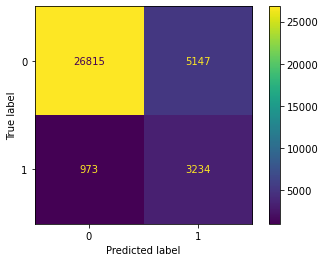

The Test Result for Classifier: LASSO
              precision    recall  f1-score   support

          no       0.97      0.85      0.91     31962
         yes       0.42      0.81      0.55      4207

    accuracy                           0.85     36169
   macro avg       0.69      0.83      0.73     36169
weighted avg       0.91      0.85      0.87     36169



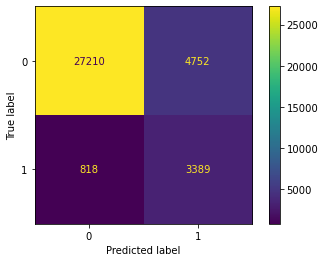

The Test Result for Classifier: Support Vector Machine
              precision    recall  f1-score   support

          no       0.95      0.80      0.87     31962
         yes       0.31      0.67      0.42      4207

    accuracy                           0.79     36169
   macro avg       0.63      0.74      0.65     36169
weighted avg       0.87      0.79      0.82     36169



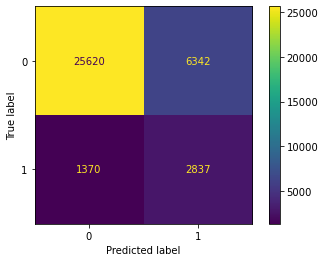

The Test Result for Classifier: k-Nearest Neighbor
              precision    recall  f1-score   support

          no       0.90      0.98      0.94     31962
         yes       0.51      0.14      0.22      4207

    accuracy                           0.88     36169
   macro avg       0.70      0.56      0.58     36169
weighted avg       0.85      0.88      0.85     36169



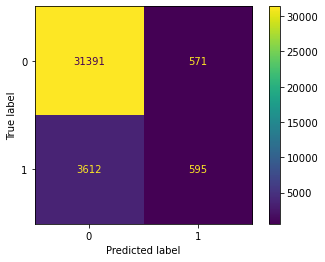

The Test Result for Classifier: ElasticNet
              precision    recall  f1-score   support

          no       0.92      0.89      0.91     31962
         yes       0.34      0.42      0.38      4207

    accuracy                           0.84     36169
   macro avg       0.63      0.66      0.64     36169
weighted avg       0.85      0.84      0.85     36169



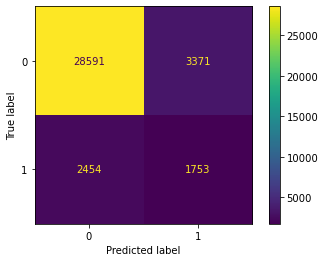

(               Classifier  Accuracy  Precision    Recall   F1Score
 1                   LASSO  0.846001   0.693551  0.828443  0.728033
 0           Random Forest  0.830794   0.675429  0.803842  0.705698
 2  Support Vector Machine  0.786779   0.629158  0.737965  0.646529
 4              ElasticNet  0.838950   0.631534  0.655609  0.641643
 3      k-Nearest Neighbor  0.884348   0.703550  0.561783  0.579506,
 [RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=888),
  LogisticRegression(class_weight='balanced', penalty='l1', random_state=888,
                     solver='liblinear'),
  SVC(C=2, class_weight='balanced', random_state=888),
  KNeighborsClassifier(n_neighbors=10),
  SGDClassifier(class_weight='balanced', l1_ratio=0.6, penalty='elasticnet',
                random_state=888)])

In [157]:
df_compare_rfe_res = compare_classifers(X_train_selected, y_train, X_test_selected, y_test, classifiers, classifier_names)
df_compare_rfe_res

## Try AutoML using H2O, NO Improvement

In [124]:
import h2o
from h2o.automl import H2OAutoML

In [125]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,7 hours 18 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_james_ghviv1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.491 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [150]:
df_h2o = df_sig.copy()
df_h2o = df_h2o.replace({'y': {1:'yes', 0:'no'}})
hf = h2o.H2OFrame(df_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [152]:
X_h2o = hf.columns
y_h2o = "y"
X_h2o.remove(y_h20)

In [160]:
aml = H2OAutoML(max_models = 10, seed = 888, balance_classes = True, max_after_balance_size=10)
aml.train(x = X_h2o, y = y_h2o, training_frame = hf)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_7_20221216_03541

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.03244559682148143
RMSE: 0.18012661330708862
LogLoss: 0.11577936455842262
AUC: 0.988406115676575
AUCPR: 0.9223450904368737
Gini: 0.97681223135315
Null degrees of freedom: 9981
Residual degrees of freedom: 9973
Null deviance: 7217.659285310792
Residual deviance: 2311.419234044349
AIC: 2329.419234044349

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4694412664921943
       no    yes    Error    Rate
-----  ----  -----  -------  --------------
no     8611  200    0.0227   (200.0/8811.0)
yes    176   995    0.1503   (176.0/1171.0)
Total  8787  1195   0.0377   (376.0/9982.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469441     0.841082  161
max f2                       0.330296     0.885425  207
max f0point5                 0.582889     0.863722  121
max accuracy                 0.473213     0.962332  160
max precision                0.941625     1         0
max recall                   0.0690796    1         322
max specificity              0.941625     1         0
max absolute_mcc             0.469441     0.819773  161
max min_per_class_accuracy   0.316884     0.944492  212
max mean_per_class_accuracy  0.248061     0.9478    236
max tns                      0.941625     8811      0
max fns                      0.941625     1168      0
max fps                      0.000330375  8811      399
max tps                      0.0690796    1171      322
max tnr                      0.941625     1         0
max fnr                      0.941625     0.997438  0
max fpr                      0.000330375  1         399
max tpr                      0.0690796    1         322

Gains/Lift Table: Avg response rate: 11.73 %, avg score: 12.53 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010018                    0.875598           8.52434   8.52434            1                0.903514     1                           0.903514            0.0853971       0.0853971                  752.434   752.434            0.0853971
2        0.0200361                   0.818427           8.52434   8.52434            1                0.844304     1                           0.873909            0.0853971       0.170794                   752.434   752.434            0.170794
3        0.0300541                   0.784659           8.35385   8.46751            0.98             0.802243     0.993333                    0.85002             0.0836892       0.254483                   735.385   746.751            0.254256
4        0.0400721                   0.74596            8.18336   8.39647            0.96             0.764514     0.985                       0.828644            0.0819812       0.336465                   718.336   739.647            0.335784
5        0.0500902                   0.711466           8.18336   8.35385            0.96             0.727486     0.98                        0.808412            0.0819812       0.418446                   718.336   735.385            0.417311
6        0.10008                     0.54871            6.67939   7.51746            0.783567         0.633907     0.881882                    0.721247            0.333903        0.752348           

In [161]:
from tensorflow import keras

In [196]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            1024, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              51200     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 330,113
Trainable params: 330,113
Non-trainable params: 0
________________________________________________

In [198]:
k_metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=k_metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
class_weight = {0: 1, 1: 8}

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=30,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    class_weight=class_weight,
)

Epoch 1/30
283/283 - 3s - loss: 1.5685 - fn: 1082.0000 - fp: 0.0000e+00 - tn: 7960.0000 - tp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6101 - val_fn: 4207.0000 - val_fp: 0.0000e+00 - val_tn: 31962.0000 - val_tp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
283/283 - 2s - loss: 1.2766 - fn: 466.0000 - fp: 4586.0000 - tn: 3374.0000 - tp: 616.0000 - precision: 0.1184 - recall: 0.5693 - val_loss: 0.7183 - val_fn: 0.0000e+00 - val_fp: 31962.0000 - val_tn: 0.0000e+00 - val_tp: 4207.0000 - val_precision: 0.1163 - val_recall: 1.0000
Epoch 3/30
283/283 - 2s - loss: 1.2726 - fn: 0.0000e+00 - fp: 7960.0000 - tn: 0.0000e+00 - tp: 1082.0000 - precision: 0.1197 - recall: 1.0000 - val_loss: 0.7329 - val_fn: 0.0000e+00 - val_fp: 31962.0000 - val_tn: 0.0000e+00 - val_tp: 4207.0000 - val_precision: 0.1163 - val_recall: 1.0000
Epoch 4/30
283/283 - 2s - loss: 1.2726 - fn: 0.0000e+00 - fp: 7960.0000 - tn: 0.0000e+00 - tp: 1082.0000 - precision: 0.1